# Summarization with blurr
> blurr is a libray I started that integrates huggingface transformers with the world of fastai v2, giving fastai devs everything they need to train, evaluate, and deploy transformer specific models.  In this article, I provide a simple example of how to use blurr's new summarization capabilities to train, evaluate, and deploy a BART summarization model.

*Updated on 08/21/2020 to use fastai 2.0.0 and also demo batch-time padding*.  
*Updated on 09/25/2020 to use on the fly batch-time tokenization*.  
*Updated on 11/12/2020 with support for fastai >= 2.1.5 and mixed precision*. 
*Updated on 12/31/2020 (too much for one sentence, see the docs for more).*

- toc: false 
- badges: true
- comments: true
- author: Wayde Gilliam
- categories: [fastai, huggingface, blurr, summarization, text generation]
- image: images/articles/blurr-logo-small.png
- hide: false
- search_exclude: false
- show_tags: true

In [24]:
# only run this cell if you are in collab
# !pip install ohmeow-blurr -q
# !pip install datasets -q
# !pip install bert-score -q

In [2]:
import datasets
import pandas as pd
from fastai.text.all import *
from transformers import *

from blurr.data.all import *
from blurr.modeling.all import *

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Data Preparation

We're going to use to use the  [datasets](https://huggingface.co/datasets) library from huggingface to grab your raw data.  This package gives you access to all kinds of NLP related datasets, explanations of each, and various task specific metrics to use in evaluating your model.  The best part being everything comes down to you in JSON!  This makes it a breeze to get up and running quickly!

We'll just use a subset of the training set to build both our training and validation DataLoaders

In [3]:
raw_data = datasets.load_dataset('cnn_dailymail', '3.0.0', split='train[:1%]')

Reusing dataset cnn_dailymail (/root/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/0128610a44e10f25b4af6689441c72af86205282d26399642f7db38fa7535602)


In [4]:
df = pd.DataFrame(raw_data)
df.head()

,article,highlights,id
0,"It's official: U.S. President Barack Obama wants lawmakers to weigh in on whether to use military force in Syria. Obama sent a letter to the heads of the House and Senate on Saturday night, hours after announcing that he believes military action against Syrian targets is the right step to take over the alleged use of chemical weapons. The proposed legislation from Obama asks Congress to approve the use of military force ""to deter, disrupt, prevent and degrade the potential for future uses of chemical weapons or other weapons of mass destruction."" It's a step that is set to turn an internat...","Syrian official: Obama climbed to the top of the tree, ""doesn't know how to get down""\nObama sends a letter to the heads of the House and Senate .\nObama to seek congressional approval on military action against Syria .\nAim is to determine whether CW were used, not by whom, says U.N. spokesman .",0001d1afc246a7964130f43ae940af6bc6c57f01
1,"(CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his third gold in Moscow as he anchored Jamaica to victory in the men's 4x100m relay. The fastest man in the world charged clear of United States rival Justin Gatlin as the Jamaican quartet of Nesta Carter, Kemar Bailey-Cole, Nickel Ashmeade and Bolt won in 37.36 seconds. The U.S finished second in 37.56 seconds with Canada taking the bronze after Britain were disqualified for a faulty handover. The 26-year-old Bolt has now collected eight gold medals at world championships, equaling the record held by American trio...",Usain Bolt wins third gold of world championship .\nAnchors Jamaica to 4x100m relay victory .\nEighth gold at the championships for Bolt .\nJamaica double up in women's 4x100m relay .,0002095e55fcbd3a2f366d9bf92a95433dc305ef
2,"Kansas City, Missouri (CNN) -- The General Services Administration, already under investigation for lavish spending, allowed an employee to telecommute from Hawaii even though he is based at the GSA's Kansas City, Missouri, office, a CNN investigation has found. It cost more than $24,000 for the business development specialist to travel to and from the mainland United States over the past year. He is among several hundred GSA ""virtual"" workers who also travel to various conferences and their home offices, costing the agency millions of dollars over the past three years. Under the program, ...","The employee in agency's Kansas City office is among hundreds of ""virtual"" workers .\nThe employee's travel to and from the mainland U.S. last year cost more than $24,000 .\nThe telecommuting program, like all GSA practices, is under review .",00027e965c8264c35cc1bc55556db388da82b07f
3,"Los Angeles (CNN) -- A medical doctor in Vancouver, British Columbia, said Thursday that California arson suspect Harry Burkhart suffered from severe mental illness in 2010, when she examined him as part of a team of doctors. Dr. Blaga Stancheva, a family physician and specialist in obstetrics, said both Burkhart and his mother, Dorothee, were her patients in Vancouver while both were applying for refugee status in Canada. ""I was asked to diagnose and treat Harry to support a claim explaining why he was unable to show up in a small-claims court case,"" Stancheva told CNN in a phone intervie...","NEW: A Canadian doctor says she was part of a team examining Harry Burkhart in 2010 .\nNEW: Diagnosis: ""autism, severe anxiety, post-traumatic stress disorder and depression""\nBurkhart is also suspected in a German arson probe, officials say .\nProsecutors believe the German national set a string of fires in Los Angeles .",0002c17436637c4fe1837c935c04de47adb18e9a
4,"(CNN) -- Police arrested another teen Thursday, the sixth suspect jailed in connection with the gang rape of a 15-year-old girl on a northern California high school campus. Jose Carlos Montano, 18, was arrested on charges of felony rape, rape in concert with force, and penetration with a foreign object, said Richmond Police L

We begin by getting our hugginface objects needed for this task (e.g., the architecture, tokenizer, config, and model).  We'll use blurr's `get_hf_objects` helper method here.

In [5]:
pretrained_model_name = "facebook/bart-large-cnn"
hf_arch, hf_config, hf_tokenizer, hf_model = BLURR_MODEL_HELPER.get_hf_objects(pretrained_model_name, 
                                                                               model_cls=BartForConditionalGeneration)

hf_arch, type(hf_config), type(hf_tokenizer), type(hf_model)

('bart',
 transformers.models.bart.configuration_bart.BartConfig,
 transformers.models.bart.tokenization_bart_fast.BartTokenizerFast,
 transformers.models.bart.modeling_bart.BartForConditionalGeneration)

Next we need to build out our DataBlock.  Remember tha a DataBlock is a blueprint describing how to move your raw data into something modelable.  That blueprint is executed when we pass it a data source, which in our case, will be the DataFrame we created above. We'll use a random subset to get things moving along a bit faster for the demo as well.

Notice that the blurr DataBlock as been dramatically simplified given the shift to on-the-fly batch-time tokenization.  All we need is to define a single `HF_Seq2SeqBeforeBatchTransform` instance, optionally passing a list to any of the tokenization arguments to differentiate the values for the input and summary sequences.  In addition to specifying a custom max length for the inputs, we can also do the same for the output sequences ... and with the latest release of blurr, we can even customize the text generation by passing in `text_gen_kwargs`.

We pass `noop` as a type transform for our targets because everything is already handled by the batch transform now.

In [6]:
text_gen_kwargs = default_text_gen_kwargs(hf_config, hf_model, task='summarization'); text_gen_kwargs

{'bad_words_ids': None,
 'bos_token_id': 0,
 'decoder_start_token_id': 2,
 'diversity_penalty': 0.0,
 'do_sample': False,
 'early_stopping': True,
 'eos_token_id': 2,
 'length_penalty': 2.0,
 'max_length': 142,
 'min_length': 56,
 'no_repeat_ngram_size': 3,
 'num_beam_groups': 1,
 'num_beams': 4,
 'num_return_sequences': 1,
 'pad_token_id': 1,
 'repetition_penalty': 1.0,
 'temperature': 1.0,
 'top_k': 50,
 'top_p': 1.0,
 'use_cache': True}

In [7]:
hf_batch_tfm = HF_Seq2SeqBeforeBatchTransform(hf_arch, hf_config, hf_tokenizer, hf_model, 
                                              max_length=256, max_tgt_length=130, text_gen_kwargs=text_gen_kwargs)

blocks = (HF_Seq2SeqBlock(before_batch_tfm=hf_batch_tfm), noop)

dblock = DataBlock(blocks=blocks, get_x=ColReader('article'), get_y=ColReader('highlights'), splitter=RandomSplitter())

In [8]:
dls = dblock.dataloaders(df, bs=2)

In [9]:
len(dls.train.items), len(dls.valid.items)

(2297, 574)

It's always a good idea to check out a batch of data and make sure the shapes look right.

In [10]:
b = dls.one_batch()
len(b), b[0]['input_ids'].shape, b[1].shape

(2, torch.Size([2, 256]), torch.Size([2, 77]))

Even better, we can take advantage of blurr's TypeDispatched version of `show_batch` to look at things a bit more intuitively.  We pass in the `dls` via the `dataloaders` argument so we can access all tokenization/modeling configuration stored in our batch transform above.

In [11]:
dls.show_batch(dataloaders=dls, max_n=2)

,text,target
0,"The news from Pakistan is generally bad news. In the past week, which was far from atypical, suicide bombers attacked a court building in the northwestern city of Peshawar taking hostages and killing four people. In the southern city of Karachi the director of a renowned social program working in the megacity's poorest neighborhoods was shot and killed. And gunmen kidnapped two female Czech tourists in southwestern Pakistan. But this past week also saw more than a glimmer of good news from Pakistan: Saturday, March 16 marked an extraordinary moment in Pakistani history, as this is the first time a civilian government has served its entire five-year term (from 2008 to 2013). And, for the first time in its history, the Pakistani military appears unwilling to mount a coup against the civilian government. The military has successfully executed three coups and attempted a number of others since Pakistan's independence in 1947. Today the army understands that the most recent coup by General Pervez Musharraf who took power in 1999 has tarnished its brand. Musharraf hung on to power for almost a decade and his imposition of emergency rule in 2007 triggered massive street protests and eventually his ouster. On Saturday, Musharaf announced he is returning to Pakistan from self-imposed exile on March 24 to","Peter Bergen: For the first time, Pakistan government served its full term.\nHe says lack of military coup attempt shows government is more stable than many think.\nElections in Pakistan, Afghanistan likely to be crucial for those two nations.\nBergen: He says Afghan economy is resilient and corruption may be receding."
1,"GALVESTON, Texas (CNN) -- Rescuers in Galveston, Texas, were going door-to-door Saturday to check on the estimated 20,000 people who failed to flee Hurricane Ike, which has slowed to tropical storm status. Park benches are strewn about in downtown Houston Saturday during Hurricane Ike. As of Saturday afternoon, the Galveston Fire Department had taken 27 people to a shelter in a high school on the coastal island, which was without electricity or water pressure. No casualties had been discovered so far in the search and rescue efforts, which have been hampered by heavy flooding and scattered debris. Galveston had ordered evacuation of the island, but Galveston City Manager Steve LeBlanc said about 40 percent of the city's 57,523 residents chose to stay. LeBlanc said the island would be closed while authorities assess damages, including to the causeway, which was in ""bad shape"" because of debris and road damage. ""The road buckled in a number of places,"" LeBlanc said. ""Even if we opened it up you couldn't get through."" LeBlanc said 17 buildings on the island had been destroyed by fires, potent winds and a strong storm surge. ""We are in","NEW: Wreckage impedes rescue efforts, adding to uncertainty about survivors.\nTexas woman wonders whether it was worth it to ride out storm in home.\nFour deaths in Texas attributed to Ike, now a tropical storm with 45 mph winds.\n2.6 million affected by power outages, U.S. Energy Department says."


## Training

We'll prepare our BART model for training by wrapping it in blurr's `HF_BaseModelWrapper` object and using the callback, `HF_BaseModelCallback`, as usual.  A new `HF_Seq2SeqMetricsCallback` object allows us to specify Seq2Seq metrics we want to use, things like rouge and bertscore for tasks like summarization as well as metrics such as meteor, bleu, and sacrebleu for translations tasks. Using huggingface's metrics library is as easy as specifying a metrics configuration such as below.

Once we have everything in place, we'll freeze our model so that only the last layer group's parameters of trainable.  See [here](https://docs.fast.ai/basic_train.html#Discriminative-layer-training) for our discriminitative learning rates work in fastai.

**Note:** This has been tested with ALOT of other Seq2Seq models; see the docs for more information.

In [12]:
seq2seq_metrics = {
        'rouge': {
            'compute_kwargs': { 'rouge_types': ["rouge1", "rouge2", "rougeL"], 'use_stemmer': True },
            'returns': ["rouge1", "rouge2", "rougeL"]
        },
        'bertscore': {
            'compute_kwargs': { 'lang': 'en' },
            'returns': ["precision", "recall", "f1"]
        }
    }

In [13]:
model = HF_BaseModelWrapper(hf_model)
learn_cbs = [HF_BaseModelCallback]
fit_cbs = [HF_Seq2SeqMetricsCallback(custom_metrics=seq2seq_metrics)]

learn = Learner(dls, 
                model,
                opt_func=ranger,
                loss_func=CrossEntropyLossFlat(),
                cbs=learn_cbs,
                splitter=partial(seq2seq_splitter, arch=hf_arch)).to_fp16()

learn.create_opt() 
learn.freeze()

Still experimenting with how to use fastai's learning rate finder for these kinds of models.  If you all have any suggestions or interesting insights to share, please let me know.  We're only going to train the frozen model for one epoch for this demo, but feel free to progressively unfreeze the model and train the other layers to see if you can best my results below.

/usr/local/lib/python3.6/dist-packages/fastai/learner.py:54: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")


SuggestedLRs(lr_min=0.06309573650360108, lr_steep=0.5248074531555176)

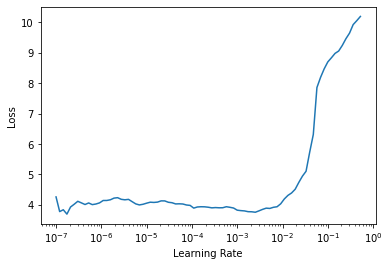

In [14]:
learn.lr_find(suggestions=True)

It's also not a bad idea to run a batch through your model and make sure the shape of what goes in, and comes out, looks right.

In [15]:
b = dls.one_batch()
preds = learn.model(b[0])
len(preds),preds[0], preds[1].shape

(3,
 tensor(4.9295, device='cuda:0', grad_fn=<NllLossBackward>),
 torch.Size([2, 68, 50264]))

In [16]:
learn.fit_one_cycle(1, lr_max=3e-5, cbs=fit_cbs)

epoch,train_loss,valid_loss,rouge1,rouge2,rougeL,bertscore_precision,bertscore_recall,bertscore_f1,time
0,1.759184,1.707277,0.377308,0.157118,0.254392,0.876762,0.891991,0.884229,14:03


And now we can look at the generated predictions using our `text_gen_kwargs` above

In [17]:
learn.show_results(learner=learn, max_n=2)

,text,target,prediction
0,"London (CNN) -- As tens of thousands of athletes, team officials and visitors gather in London ahead of the Olympic opening ceremony on Friday, security is paramount for the Games organizers and British authorities. And perhaps the biggest headache of all is the challenge of safeguarding the more than 100 heads of state and foreign dignitaries who will attend the opening ceremony at the Olympic Park -- Queen Elizabeth II, first lady Michelle Obama and U.S. presidential hopeful Mitt Romney among them. But should visitors and competitors be worried? Security concerns hit the headlines this month when it emerged that private security contractor G4S, which was supposed to have provided 10,400 guards for the Olympics and Paralympics, would not be able to deliver. As a result, the government is deploying 18,200 troops -- many more than planned and almost twice as many as are in Afghanistan -- in order to remedy the shortfall. About 1,200 of those were called up just this week after being placed on standby. Nonetheless, Culture Secretary Jeremy Hunt, the minister responsible for the Games, said Tuesday that the government ""continues to have every confidence that we will deliver a safe and secure Games."" The decision to call up the extra troops was down to ministers' determination to ""leave nothing to chance","The government is deploying 18,200 troops to make up for a shortfall in security guards.\nOne headache is safeguarding more than 100 visiting heads of state and foreign dignitaries.\nPrivate security contractor G4S has failed to recruit and accredit enough security staff.\nFighter jets are on standby, and a helicopter carrier is moored in the Thames.","Security concerns hit the headlines this month when it emerged that security contractor G4S would not be able to deliver .\nThe government is deploying 18,200 troops -- many more than planned and almost twice as many as are in Afghanistan .\nMore than 100 heads of state and foreign dignitaries will attend the opening ceremony at the Olympic Park ."
1,"Washington (CNN) -- In one ill-fated fundraiser, Mitt Romney managed to offend Palestinians, Latinos and some of the same people he's counting on for support if he wants to unseat President Barack Obama. It isn't the first time Romney's oratory fumbles have put his campaign on its heels, handed opponents material to push the stereotype of him as an out-of-touch businessman and provoked members of the party's conservative base to question his worthiness as their standard-bearer. ""Everybody has the same reaction: 'dumb, dumb, dumb,'"" said Larry Sabato, director of the University of Virginia's Center for Politics, adding that Romney's gaffes reinforce a sitcom-like caricature of the candidate. Opinion: What's wrong with Romney. After the tape, recorded during a May 17 private fundraiser at the home of Sun Capital executive Marc Leder, made the rounds on Monday, Romney convened a hastily scheduled news conference Monday night in which he said his comments were ""off the cuff"" and ""not elegantly stated."" However, he defended the main message of his remarks, saying he that while he could have made them ""more clearly,"" he said he was trying to point out the differences between his and Obama's campaigns.","GOP presidential candidate Mitt Romney's verbal gaffes have once again stymied his campaign's ability to control the narrative.\nDemocrats were gleeful, while Republicans left scrambling after Romney's comments.\nLess than two months before the election, Romney's challenge is to steer clear of speaking slip ups; hammer Obama on the economy.","Romney's gaffes reinforce a sitcom-like caricature of the candidate, professor says .\nHe says he was trying to point out the differences between his and President Obama's campaigns .\nThe gaffe came during a May 17 fundraiser at the home of Sun Capital executive Marc Leder .\nAfter the tape made the rounds on Monday, Romney convened a hastily scheduled news confer

Even better though, blurr augments the fastai Learner with a `blurr_summarize` method that allows you to use huggingface's `PreTrainedModel.generate` method to create something more human-like.

In [19]:
test_article = """
The past 12 months have been the worst for aviation fatalities so far this decade - with the total of number of people killed if airline 
crashes reaching 1,050 even before the Air Asia plane vanished. Two incidents involving Malaysia Airlines planes - one over eastern Ukraine and the other in the Indian Ocean - led to the deaths of 537 people, while an Air Algerie crash in Mali killed 116 and TransAsia Airways crash in Taiwan killed a further 49 people. The remaining 456 fatalities were largely in incidents involving small commercial planes or private aircraft operating on behalf of companies, governments or organisations. Despite 2014 having the highest number of fatalities so far this decade, the total number of crashes was in fact the lowest since the first commercial jet airliner took off in 1949 - totalling just 111 across the whole world over the past 12 months. The all-time deadliest year for aviation was 1972 when a staggering 2,429 people were killed in a total of 55 plane crashes - including the crash of Aeroflot Flight 217, which killed 174 people in Russia, and Convair 990 Coronado, which claimed 155 lives in Spain. However this year's total death count of 1,212, including those presumed dead on board the missing Air Asia flight, marks a significant rise on the very low 265 fatalities in 2013 - which led to it being named the safest year in aviation since the end of the Second World War. Scroll down for videos. Deadly: The past 12 months have been the worst for aviation fatalities so far this decade - with the total of number of people killed if airline crashes reaching 1,158 even before the Air Asia plane (pictured) vanished. Fatal: Two incidents involving Malaysia Airlines planes - one over eastern Ukraine (pictured) and the other in the Indian Ocean - led to the deaths of 537 people. Surprising: Despite 2014 having the highest number of fatalities so far this decade, the total number of crashes was in fact the lowest since the first commercial jet airliner took off in 1949. 2014 has been a horrific year for Malaysia-based airlines, with 537 people dying on Malaysia Airlines planes, and a further 162 people missing and feared dead in this week's Air Asia incident. In total more than half the people killed in aviation incidents this year had been flying on board Malaysia-registered planes. In January a total of 12 people lost their lives in five separate incidents, while the same number of crashes in February killed 107. 
"""

We can override the `text_gen_kwargs` we specified for our `DataLoaders` when we generate text using blurr's `Learner.blurr_generate` method

In [20]:
outputs = learn.blurr_generate(test_article, early_stopping=True, num_beams=4, num_return_sequences=3)

for idx, o in enumerate(outputs):
    print(f'=== Prediction {idx+1} ===\n{o}\n')

=== Prediction 1 ===
 2014 has been the worst year for aviation fatalities so far this decade so far .
The total number of people killed if airline crashes reached 1,158 even before Air Asia plane vanished .
Two incidents involving Malaysia Airlines planes led to the deaths of 537 people in the past 12 months .
Despite 2014 having the highest number of fatalities, the number of crashes was in fact the lowest since first commercial jet airliner took off in 1949 - totalling just 111 across the whole world .

=== Prediction 2 ===
 2014 has been the worst year for aviation fatalities so far this decade so far .
The total number of people killed if airline crashes reached 1,158 even before Air Asia plane vanished .
Two incidents involving Malaysia Airlines planes led to the deaths of 537 people in the past 12 months .
Despite 2014 having the highest number of fatalities, the number of crashes was in fact the lowest since first commercial jet airliner took off in 1949 - totalling just 111 ac

What about inference?  Easy!

In [21]:
learn.metrics = None
learn.export(fname='ft_cnndm_export.pkl')

In [23]:
inf_learn = load_learner(fname='ft_cnndm_export.pkl')
inf_learn.blurr_generate(test_article)

[' 2014 has been the worst year for aviation fatalities so far this decade so far .\nThe total number of people killed if airline crashes reached 1,158 even before Air Asia plane vanished .\nTwo incidents involving Malaysia Airlines planes led to the deaths of 537 people in the past 12 months .\nDespite 2014 having the highest number of fatalities, the number of crashes was in fact the lowest since first commercial jet airliner took off in 1949 - totalling just 111 across the whole world .']

## That's it

[blurr](https://ohmeow.github.io/blurr/) supports a number of huggingface transformer model tasks in addition to summarization (e.g., sequence classification , token classification, and question/answering, causal language modeling, and transation). The docs include examples for each of these tasks if you're curious to learn more.

For more information about ohmeow or to get in contact with me, head over to [ohmeow.com](ohmeow.com) for all the details.

Thanks!